In [1]:
# MNIST with an MLP, from scratch

# - Step 1: build an MLP from scratch to solve MNIST. Question set: https://fleuret.org/dlc/materials/dlc-practical-3.pdf
# - Step 2: debug your network with backprop ninja and a reference implementation using torch's .backward()
# - Step 3: build the same MLP but will full pytorch code (nn.Linear, etc.)

In [2]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from utils import load_data

In [4]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


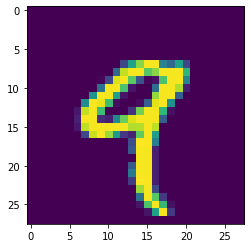

In [5]:
plt.imshow(train_input[4].view((28,28)))

In [6]:
def compute_accuracy (preds, targets):
    """ Computes the accuracy between predictions and targets. Data is expected to be one-hot encoded. """
    _, idx1 = torch.max(preds, dim=1)
    _, idx2 = torch.max(targets, dim=1)
    d = idx1 == idx2
    return d.int().float().mean().item()

In [7]:
# unit test
# this cell should return 0.75
preds = torch.zeros((4,7))
preds[0,1] = 1
preds[1,4] = 1
preds[2,2] = 1
preds[3,6] = 1
targets = torch.zeros((4,7))
targets[0,1] = 1
targets[1,4] = 1
targets[2,2] = 1
targets[3,2] = 1
compute_accuracy(preds, targets)

0.75

In [8]:
def sigma(x):
    return torch.tanh(x)

def dsigma(x):
    return 1 - torch.pow(sigma(x), 2)

In [9]:
def loss (v,t):
    return(torch.sum (torch.pow(v-t,2)))

def dloss(v,t):
    return torch.mul(2, (v-t))

In [10]:
# sanity check
v = torch.randn((3, 6), dtype=torch.float32)
t = torch.randn((3, 6), dtype=torch.float32)
l=loss(v,t)
dloss(v,t)

tensor([[ 0.1356, -0.0373,  2.5635, -0.3601,  1.0764,  0.6171],
        [ 2.4355,  0.2436,  2.4944,  1.1067, -1.4013, -0.7925],
        [ 2.6075, -5.9662,  6.2123, -3.6598,  4.7771,  4.0356]])

In [11]:
# multiply targets by 0.9 to be in the range of tanh
train_target *= 0.9
test_target *= 0.9

### Step 1: Backprop ninja

In [12]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
# DO NOT MODIFY IT
#
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [13]:
torch.manual_seed(1337)
w1 = torch.ones((784, 50), requires_grad=True)
b1 = torch.ones((50), requires_grad=True)
w2 = torch.ones((50, 10), requires_grad=True)
b2 = torch.ones((10), requires_grad=True)
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad = True

In [14]:
x1 = train_input[:5]
y1 = train_target[:5]
z1 = x1 @ w1 + b1.t()
h1 = sigma(z1)
z2 = h1 @ w2 + b2.t()
h2 = sigma(z2)
l = loss(h2, y1)
h2.shape, l

(torch.Size([5, 10]), tensor(55.8500, grad_fn=<SumBackward0>))

In [15]:
# Force pytorch to retain grade for intermediate nodes and reset grad for parameters
# DO NOT MODIFY THIS CODE
#
others = [h2,z2,h1,z1]
for p in parameters:
    p.grad = None
for t in others:
    t.retain_grad()
l.backward()
print(f'loss={l}')

loss=55.849998474121094


In [16]:
b2.grad.shape

torch.Size([10])

In [17]:
# here we compare our gradient to the reference gradient computed by pytorch
dl = 1.0
dh2 = dloss(h2, y1)
cmp('h2',dh2,h2)
dz2 = torch.mul(dh2, dsigma(z2))
cmp('z2',dz2, z2)
dw2 = h1.t() @ dz2
cmp('w2',dw2, w2)
db2 = dz2.sum(0).reshape(b2.shape)
cmp('b2',db2, b2)
dh1 = dz2 @ w2.t()
cmp('h1',dh1, h1)
dz1 = torch.mul(dh1, dsigma(z1))
cmp('z1', dz1, z1)
dw1 = x1.t() @ dz1
cmp('w1', dw1, w1)
db1 = dz1.sum(0).reshape(b1.shape)
cmp('b1', db1, b1)


h2              | exact: True  | approximate: True  | maxdiff: 0.0
z2              | exact: True  | approximate: True  | maxdiff: 0.0
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h1              | exact: True  | approximate: True  | maxdiff: 0.0
z1              | exact: True  | approximate: True  | maxdiff: 0.0
w1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [18]:
lr = 0.1
with torch.no_grad():
    w1 += -lr * dw1
    #print(f'b1:{b1.shape}, \n db1:{db1.squeeze().shape}')
    b1 += -lr * db1.squeeze()
    w2 += -lr * dw2
    b2 += -lr * db2.squeeze()

In [19]:
l = loss(h2, y1)
l.item()

55.849998474121094

##### Now that we've checked our gradients are correct, we can implement the network

In [20]:
def forward(w1, b1, w2, b2, x):
    z1 = x @ w1 + b1.t()
    h1 = sigma(z1)
    z2 = h1 @ w2 + b2.t()
    h2 = sigma(z2)
    return z1, h1, z2, h2


In [28]:
def backward(w1, b1, w2, b2, x1, y1, h2, z2, h1, z1):
    dl = 1.0
    dh2 = dloss(h2, y1)
    dz2 = torch.mul(dh2, dsigma(z2))
    dw2 = h1.t() @ dz2
    db2 = dz2.sum(0).reshape(b2.shape)
    dh1 = dz2 @ w2.t()
    dz1 = torch.mul(dh1, dsigma(z1))
    dw1 = x1.t() @ dz1
    db1 = dz1.sum(0).reshape(b1.shape)
        
    return dw1, db1, dw2, db2

In [22]:
def update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr):
    with torch.no_grad():
        w1 += -lr * dw1
        b1 +=  -lr * db1.squeeze()
        w2 += -lr * dw2
        b2 += -lr * db2.squeeze()
    return w1, b1, w2, b2

In [23]:
def init():
    """ init a network """
    torch.manual_seed(1337)
    return w1, b1, w2, b2

In [24]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [29]:
# main training loop
torch.set_printoptions(linewidth=200)
def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        lsi = loss(h2, yb)
        # backward
        dw1, db1, dw2, db2 = backward(w1, b1, w2, b2, xb, yb, h2, z2, h1, z1)
        # update
        lr = 0.1 / num_samples if step < 5000 else 0.01 / num_samples
        w1, b1, w2, b2 = update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr)
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

        
    

In [30]:
lossi = train(w1, b1, w2, b2)


step = 0, loss = 10828.0
step = 100, loss = 10828.0
step = 200, loss = 10828.0
step = 300, loss = 10828.0
step = 400, loss = 10828.0
step = 500, loss = 10828.0
step = 600, loss = 10828.0
step = 700, loss = 10828.0
step = 800, loss = 10828.0
step = 900, loss = 10828.0
step = 1000, loss = 10828.0
step = 1100, loss = 10828.0
step = 1200, loss = 10828.0
step = 1300, loss = 10828.0
step = 1400, loss = 10828.0
step = 1500, loss = 10828.0
step = 1600, loss = 10828.0
step = 1700, loss = 10828.0
step = 1800, loss = 10828.0
step = 1900, loss = 10828.0
step = 2000, loss = 10828.0
step = 2100, loss = 10828.0
step = 2200, loss = 10828.0
step = 2300, loss = 10828.0
step = 2400, loss = 10828.0
step = 2500, loss = 10828.0
step = 2600, loss = 10828.0
step = 2700, loss = 10828.0
step = 2800, loss = 10828.0
step = 2900, loss = 10828.0
step = 3000, loss = 10828.0
step = 3100, loss = 10828.0
step = 3200, loss = 10828.0
step = 3300, loss = 10828.0
step = 3400, loss = 10828.0
step = 3500, loss = 10828.0
step

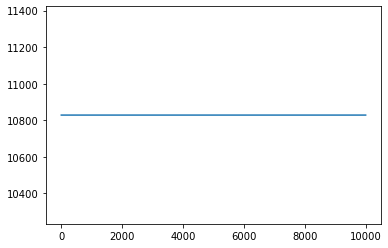

In [31]:
plt.plot(lossi)
#print(lossi)

### Step 2: Reference implementation using pytorch's .backward()
Nothing to do in Step 2, this code is provided for you as a reference

In [ ]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [ ]:
# reference code
torch.set_printoptions(linewidth=200)
import torch.nn as F

def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        xloss = F.MSELoss()
        lsi = xloss(h2, yb) * yb.nelement()
        # backward
        for p in parameters:
            p.grad = None
        lsi.backward()
        # update
        lr = 0.1 / num_samples
        for p in parameters:
            p.data += -lr * p.grad
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [ ]:
lossi = train(w1, b1, w2, b2)

In [ ]:
plt.plot(lossi)

### Step 3: Build the same MLP layer but with fully pytorch code (nn.Linear(), etc.)

In [ ]:
# network dimensions
n_in = 784
n_hidden = 200
n_out = 10

In [ ]:
X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

In [ ]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            ???
        ))

    def __call__(self, x):
        ???
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters]

model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [ ]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.???
    loss.backward()
    optimizer.???
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')




##### Exercise: try to improve accuracy!